In [1]:

import matplotlib.pyplot as plt
from src.data_loading.torch_data_utils import load_data_with_logging

# Load data
data_dir = "data/KAU"
dataloaders = load_data_with_logging(data_dir)

# Print the shape of the training data
images, labels = next(iter(dataloaders['train']))
print(f"Training batch shape: {images.shape}")

# Print the shape of the validation data
images, labels = next(iter(dataloaders['val']))
print(f"Validation batch shape: {images.shape}")

Training batch shape: torch.Size([32, 3, 224, 224])
Validation batch shape: torch.Size([32, 3, 224, 224])


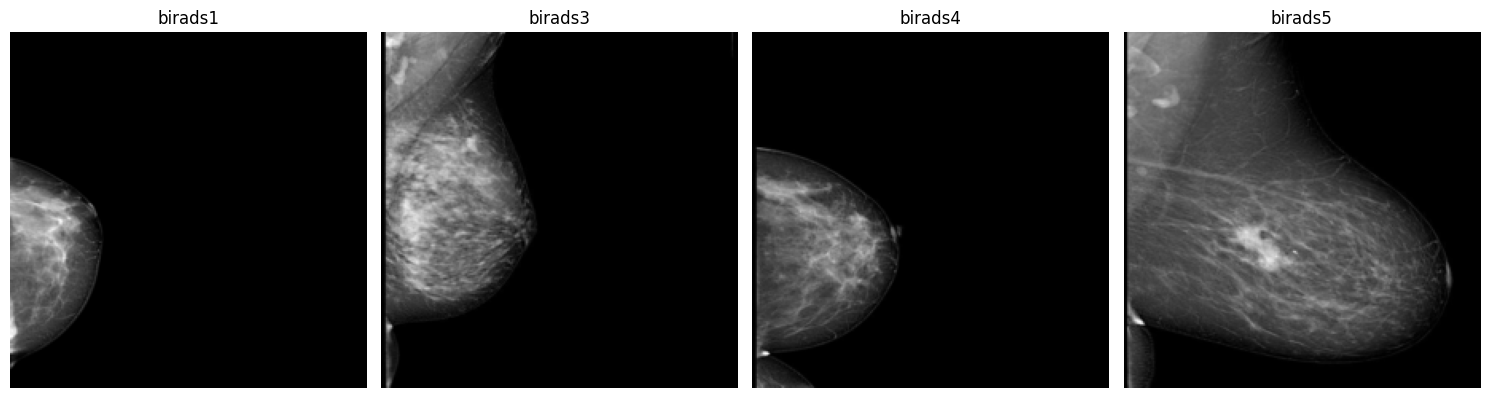

In [ ]:
# Get class names
class_names = dataloaders['train'].dataset.classes

# Plot one image from each class
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for i, class_name in enumerate(class_names):
    found = False
    for images, labels in dataloaders['train']:
        mask = (labels == i).nonzero(as_tuple=True)[0]
        if mask.numel() > 0:
            idx = mask[0]
            image = images[idx].permute(1, 2, 0).numpy()
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
            axes[i].imshow(image)
            axes[i].set_title(class_name)
            axes[i].axis('off')
            found = True
            break
    if not found:
        axes[i].set_title(f"{class_name}\n(Not Found)")
        axes[i].axis('off')
plt.tight_layout()
plt.show()